In [98]:
import os
from glob import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import _pickle as pickle

# 데이터셋 구성
    학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
    로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
    tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


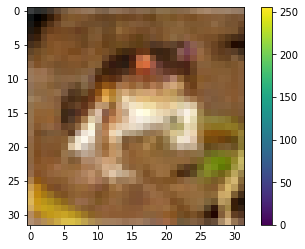

In [3]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


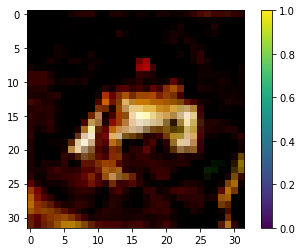

In [5]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

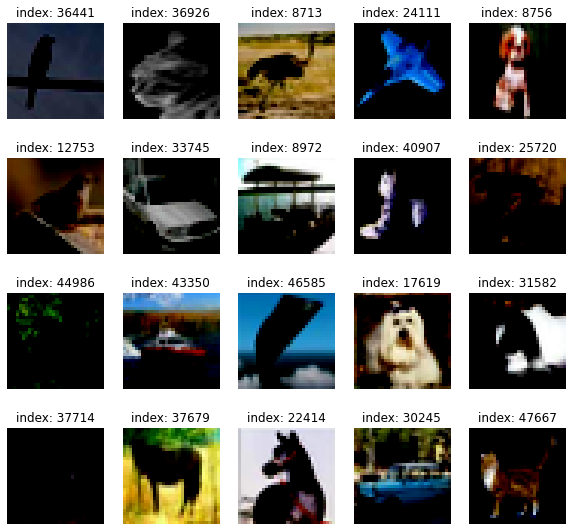

In [6]:
plt.figure(figsize=(10, 12))

for i in range(20):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 모델 구현

In [8]:
noise = tf.random.normal([1,100])

In [8]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


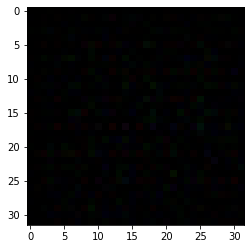

In [12]:
# for i in range(3):
plt.imshow(generated_image[0])

# plt.colorbar()
plt.show()

# 판별자 모델

In [10]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [15]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [21]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, 100])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

(100,)

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))

    pred = predictions.numpy() 
    pred_reve = (pred * 127.5) + 127.5   # reverse of normalization
    pred_reve = pred_reve.astype(int)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred_reve[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))

    pred = predictions.numpy() 
    pred_reve = (pred * 127.5) + 127.5   # reverse of normalization
    pred_reve = pred_reve.astype(int)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred_reve[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()


def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [18]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [26]:
save_every = 5
EPOCHS = 50

# train(train_dataset, EPOCHS, save_every)


In [48]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 1363169  2월 28 23:27 /home/aiffel-dj26/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


# 저장된 모델 부르기

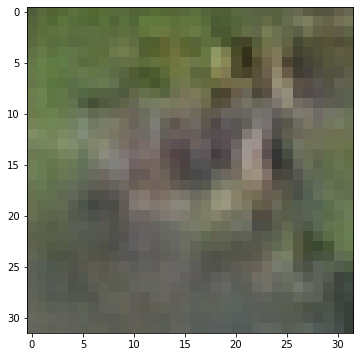

In [46]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [100]:
%%time
train(train_dataset, EPOCHS, save_every)

In [99]:
# 다시 gif 파일로 저장 gif 이름 수정하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/acgan/fashion_mnist_dcgan6.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob('{}/aiffel/dcgan_newimage/acgan/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 1363169  2월 28 23:27 /home/aiffel-dj26/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


# 새로운 모델 구상 (ACGAN)
라벨 추가



In [57]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
from collections import defaultdict
import _pickle as pickle
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from six.moves import range
from glob import glob
models = tf.keras.models
layers = tf.keras.layers
utils = tf.keras.utils
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image
datasets = tf.keras.datasets

In [61]:
cif10 = tf.keras.datasets.cifar10

(train_x, y_train), (test_x, y_test) = cif10.load_data()


X_train = (train_x.astype(np.float32) - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
X_test = (test_x.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print(X_train.shape)
print(X_test.shape)

nb_train, nb_test = X_train.shape[0], X_test.shape[0]

(50000, 32, 32, 3, 1)
(10000, 32, 32, 3, 1)


# 생성자 모델 구성(input 2개)

In [50]:
def generator(latent_size, classes=10):

    def up_sampling_block(x, filter_size):
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = layers.Conv2D(filter_size, (5,5), padding='same', activation='relu')(x)
        return x

    # Input 1
    # image class label
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')

    # class embeddings
    emb = layers.Embedding(classes, latent_size,
                           embeddings_initializer='glorot_normal')(image_class)

    # 10 classes in MNIST
    cls = layers.Flatten()(emb)

    # Input 2
    # latent noise vector
    latent_input = layers.Input(shape=(latent_size,), name='latent_noise')

    # hadamard product between latent embedding and a class conditional embedding
    h = layers.multiply([latent_input, cls])

    # Conv generator
    x = layers.Dense(1024, activation='relu')(h)
    x = layers.Dense(128 * 8 * 8, activation='relu')(x)
    x = layers.Reshape((8, 8, 128))(x)

    # upsample to (14, 14, 128)
    x = up_sampling_block(x, 256)

    # upsample to (32, 32, 256)
    x = up_sampling_block(x, 128)

    # reduce channel into binary image (32, 32, 3)
    generated_img = layers.Conv2D(3, (2,2), padding='same', activation='tanh')(x)

    return models.Model(inputs=[latent_input, image_class],
                        outputs=generated_img,
                        name='generator')

In [4]:
noise = tf.random.normal([1,100])

# a = Acgenerator_model(noise,train_y)

In [5]:
a = Acgenerator_model()

In [6]:
a.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        1638400     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16384)        65536       dense[0][0]                      
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

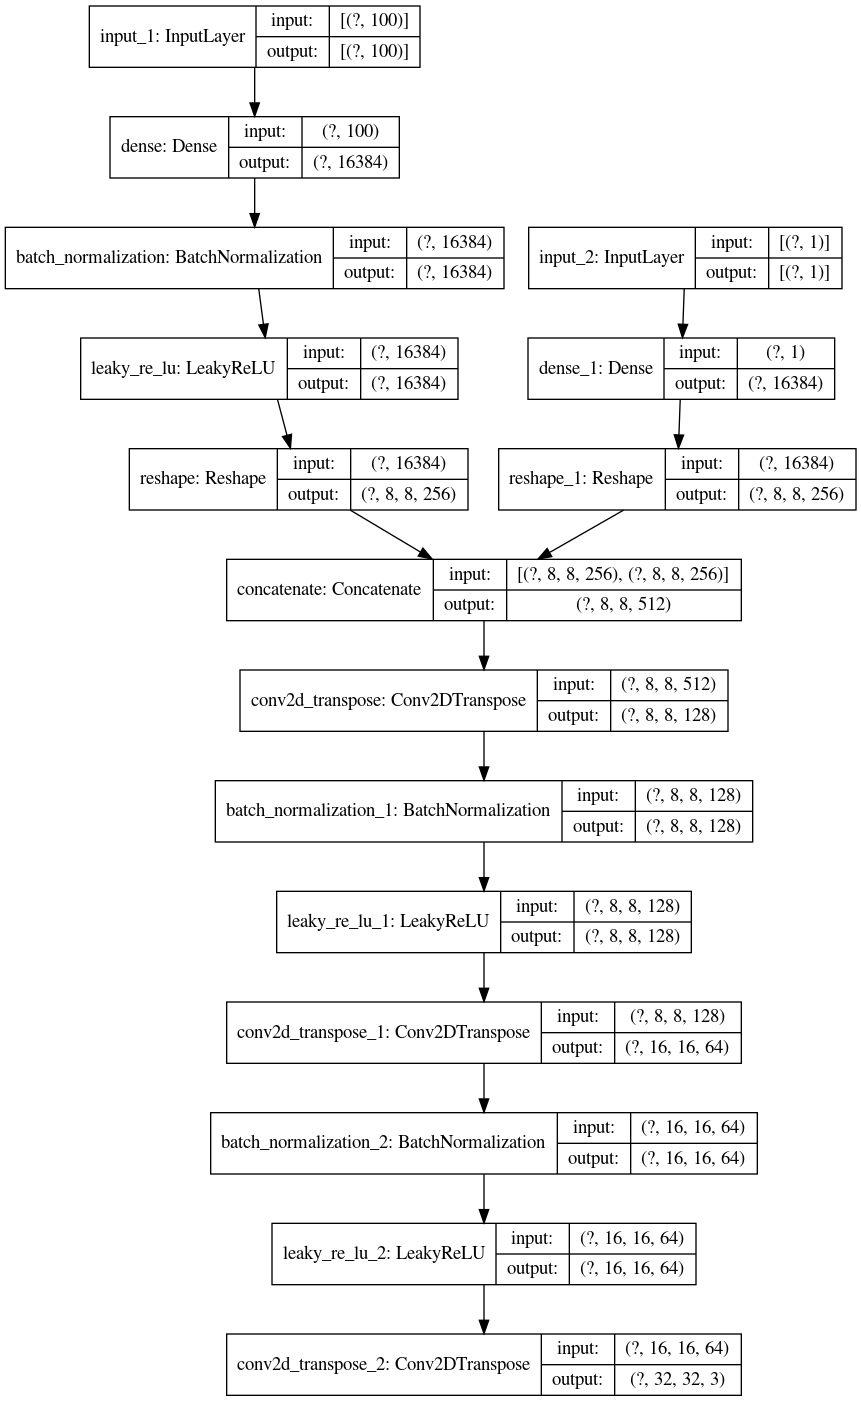

In [14]:
keras.utils.plot_model(a, "multi_input_and_output_model.png", show_shapes=True)

In [51]:
def discriminator(input_shape=(32, 32, 3)):

    def conv_block(x, filter_size, stride):
        x = layers.Conv2D(filter_size, (3,3), padding='same', strides=stride)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)
        return x

    input_img = layers.Input(shape=input_shape)

    x = conv_block(input_img, 32, (2,2))
    x = conv_block(x, 64, (1,1))
    x = conv_block(x, 128, (2,2))
    x = conv_block(x, 256, (1,1))

    features = layers.Flatten()(x)

    # binary classifier, image fake or real
    fake = layers.Dense(1, activation='sigmoid', name='generation')(features)

    # multi-class classifier, image digit class
    aux = layers.Dense(10, activation='softmax', name='auxiliary')(features)


    return models.Model(inputs=input_img, outputs=[fake, aux], name='discriminator')

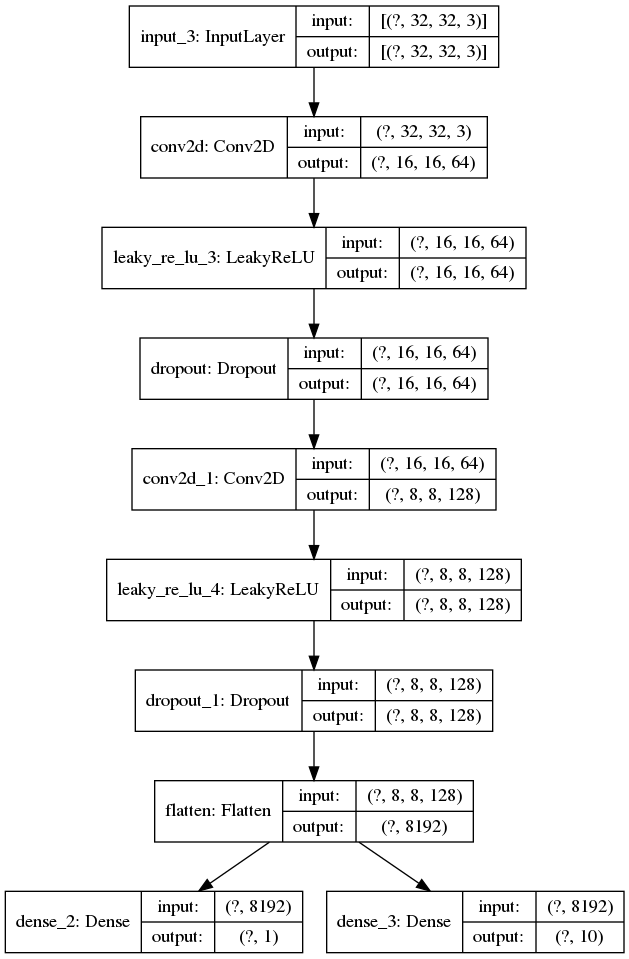

In [14]:
keras.utils.plot_model(b, show_shapes=True)

In [9]:
b.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 16, 64)   0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

In [82]:
ac = a.predict([noise,train_y[0]])
print(ac.shape)
plt.imshow(ac[0])
bp =b.predict(ac)
Acgenerator = Acgenerator_model()
Acdis = Ac_dis_ml()

In [26]:
Acgenerator = Acgenerator_model()
Acdis = Ac_dis_ml()
def fakeAcGan(noise,train_y):
    img = Acgenerator([noise,train_y])
    return [img,train_y]

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy
    
generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

In [22]:
BATCH_SIZE = 256
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, 100])  #(2) 생성자 입력 노이즈
    rdrable = np.random.randint(0,10,BATCH_SIZE)
    with tf.GradientTape() as ge_tape,tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as dis_tape:  #(3) tf.GradientTape() 오픈
        
        generated_images = Acgenerator([noise,rdrable])  #(4) generated_images 생성
        
        #(5) discriminator 판별
        real_output = Acdis(images)
        fake_output = Acdis(generated_images)

        #(6) loss 계산
        # fake_output = layers.concatenate(fake_output)
        # real_output = layers.concatenate(real_output)    
        # gen_loss = generator_loss(fake_output)
        gen_loss = generator_loss(fake_output[1])
        gen_loss1 = generator_loss(fake_output[0])
        disc_loss1 = discriminator_loss(real_output[0], fake_output[0])
        # disc_loss = discriminator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output[1], fake_output[1])
        #(7) accuracy 계산
        real_accuracy1, fake_accuracy1 = discriminator_accuracy(real_output[0], fake_output[0]) 
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output[1], fake_output[1])
        # real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, Acgenerator.trainable_variables)
    gradients_of_generator1 = ge_tape.gradient(gen_loss1, Acgenerator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, Acdis.trainable_variables)
    gradients_of_discriminator1 = dis_tape.gradient(disc_loss1, Acdis.trainable_variables)
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, Acgenerator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator1, Acgenerator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, Acdis.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator1, Acdis.trainable_variables))
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).batch(BATCH_SIZE)

In [9]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds)

    fig = plt.figure(figsize=(4, 4))

    pred = predictions.numpy() 
    pred_reve = (pred * 127.5) + 127.5   # reverse of normalization
    pred_reve = pred_reve.astype(int)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred_reve[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/acgan/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()


def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/acgan/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/acgan/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 Acgenerator=Acgenerator,
                                 Acdis=Acdis)

In [10]:
save_every = 5
EPOCHS = 50

def train(dataset, epochs, save_every):
    
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(Acgenerator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(Acgenerator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [11]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])gradients_of_discriminator1
rdrable1 = np.random.randint(0,10,16)
seed = [seed,rdrable1]
seed


[<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
 array([[ 0.93351513, -0.7071738 , -0.59018284, ...,  1.0220586 ,
          0.36552912,  0.5171506 ],
        [-0.3607066 , -3.0015016 , -1.6021814 , ..., -0.20452361,
         -0.25856397,  1.3687223 ],
        [ 0.6111998 , -2.3273392 , -0.4922211 , ...,  1.0893704 ,
         -0.0643709 ,  1.1314775 ],
        ...,
        [-2.8378766 ,  0.9263511 ,  1.8706086 , ...,  0.01476635,
          2.1467261 , -0.11682333],
        [-1.0877074 ,  1.5782728 , -0.40604556, ..., -0.6423493 ,
         -1.300181  , -0.9313976 ],
        [ 0.08079099, -0.7688581 , -1.197142  , ..., -0.65152735,
         -0.8202402 , -1.2758201 ]], dtype=float32)>,
 array([6, 9, 6, 2, 9, 4, 9, 4, 9, 7, 7, 3, 2, 2, 5, 0])]

In [96]:
train(train_dataset, EPOCHS, save_every)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(1, 32, 32, 3)


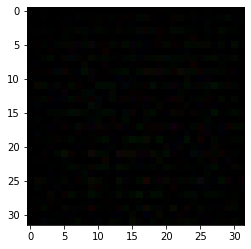

In [15]:
noise = tf.random.normal([1,100])
ac = a.predict([noise,train_y[0]])
print(ac.shape)
plt.imshow(ac[0])
bp =b.predict(ac)


## Acgan 모델 실패
하.. 욕심이 너무 컸던 탓인가 아직 Tape로 모델 돌리는 것에 대한 이해도가 매우 떨어지는 상태로 비슷하게 적용하고 싶어 이것저것 자료 찾아보며 힘들게 만든 모델이었다.
모델 돌리는것 까지는 겨우겨우 했지만 문제는 loss를 줄이고 accurate를 올려야하는데 전혀진전이 없었다.  
이유를 생각하자면 그래디언트값이 아웃풋이 두개다 보니 2개가 나오는데 자동계산해주는 Tape에 대한 이해도가 전무한 상태에서 어떤값을 사용해야 할지 모르고 여러 시도를 했지만 결국 다 실패로 돌아갔다. 그래서 그냥 인터넷에 돌아다니는 튜토리얼로 진행하려 했지만 너무 오래된 것들이라(아직 Tensorflow가 keras를 먹기전) 모듈실행에 어려움이있고 새로새로 다시 이해하고 변형해야 되어서 포기하게되었다.
그래도 뭔가 일을 진행했다는 것을 사진으로 남기며 마무리하겠습니다.  
![](./image/train.png)  
![](./image/111.gif)


# Dcgan 모델 결과 값
![](./image/1111.gif)  
![](./image/1111.png)  
![](./image/222.png)

# 고찰
gan의 모델끼리 서로서로 배운다는 개념이 신기하여 더 추가적인 것을 하고싶었지만 아쉽게도 실패에 돌아갔다.  
input,ouput이 여러 개일 때 모델이 어떻게 돌아가야하는지 감이 안오는 것을 보고 아직 이 시스템을 이해를 못하고 있구나를 느끼며,  
loss,opimize,complie에 좀더 집중해서 공부하면 이번 문제를 해결할 가능성을 보았다. 좀 더 구글링능력을 키워 봐야할 것 같기도 하지만 기초가 더 중요하다는 것을 뼈 저리게 느꼈다.
